# Normalizing flows: parameter estimation using Optim and FiniteDiff

## Load packages

In [1]:
using Random
using LinearAlgebra
using PyPlot
using Distributions
using BenchmarkTools
using ProgressMeter
using Optim
using Revise

using ReactiveMP
using GraphPPL
using Rocket;

## Generate data

In [2]:
function generate_data(nr_samples::Int64, model::FlowModel)

    # specify latent sampling distribution
    dist = MvNormal([1.5, 0.5], I)

    # sample from the latent distribution
    x = rand(dist, nr_samples)

    # transform data
    y = zeros(Float64, size(x))
    for k = 1:nr_samples
        y[:,k] .= forward(model, x[:,k])
    end

    # return data
    return y, x

end;

In [3]:
data_model = FlowModel((AdditiveCouplingLayer(PlanarFlow(5.0, -5.0, 5.0)),
                        AdditiveCouplingLayer(PlanarFlow(-5.0, 5.0, 1.0))))
data_y, data_x = generate_data(1000, data_model);

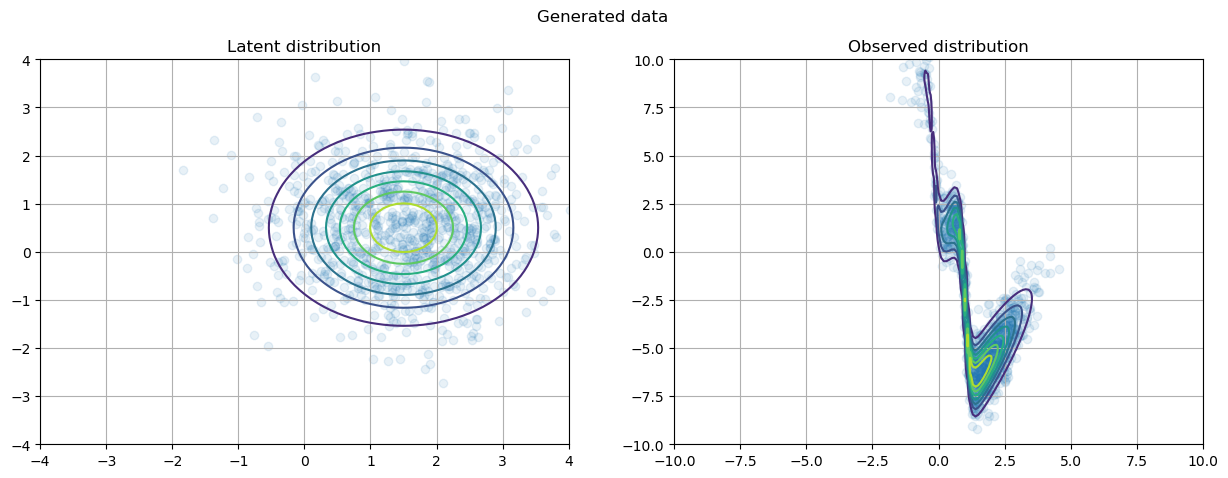

In [4]:
fig, ax = plt.subplots(ncols = 2, figsize=(15,5))
ax[1].scatter(data_x[1,:], data_x[2,:], alpha=0.1)
ax[1].contour(repeat(-5:0.1:5, 1, 101), repeat(-5:0.1:5, 1, 101)', map( (x) -> pdf(MvNormal([1.5, 0.5], I), [x...]), collect(Iterators.product(-5:0.1:5, -5:0.1:5))))
ax[2].scatter(data_y[1,:], data_y[2,:], alpha=0.1)
ax[2].contour(repeat(-10:0.1:10, 1, 201), repeat(-10:0.1:10, 1, 201)', map( (x) -> pdf(MvNormal([1.5, 0.5], I), backward(data_model, [x...])), collect(Iterators.product(-10:0.1:10, -10:0.1:10))))
ax[1].grid(), ax[2].grid()
ax[1].set_xlim(-4,4), ax[1].set_ylim(-4,4), ax[2].set_xlim(-10,10), ax[2].set_ylim(-10,10)
fig.suptitle("Generated data")
ax[1].set_title("Latent distribution"), ax[2].set_title("Observed distribution");

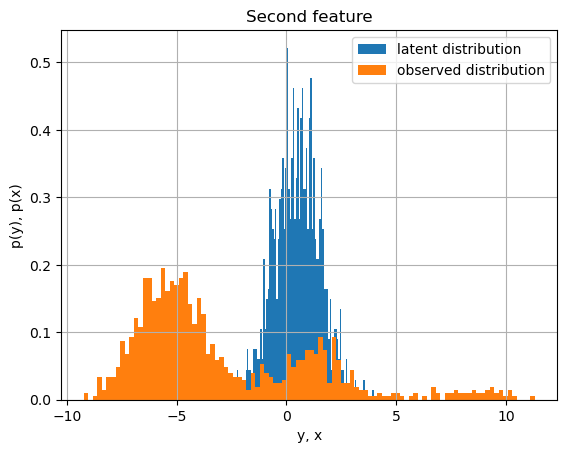

In [5]:
plt.hist(data_x[2,:], bins=100, density=true, alpha=1.0, label="latent distribution")
plt.hist(data_y[2,:], bins=100, density=true, alpha=1.0, label="observed distribution")
plt.grid(), plt.legend(), plt.ylabel("p(y), p(x)"), plt.xlabel("y, x"), plt.title("Second feature");
# first feature stays the same throughout the NICE flow

## Model specification

In [6]:
@model function normalizing_flow(nr_samples::Int64, params)
    
    # initialize variables
    x_lat     = randomvar(nr_samples)
    y_lat = randomvar(nr_samples)
    y     = datavar(Vector{Float64}, nr_samples)
    x     = datavar(Vector{Float64}, nr_samples)

    # specify model
    model = FlowModel( (AdditiveCouplingLayer(PlanarFlow(params[1], params[2], params[3])),
                        AdditiveCouplingLayer(PlanarFlow(params[4], params[5], params[6]))))
    meta = FlowMeta(model)

    # specify observations
    for k = 1:nr_samples

        # specify latent state
        x_lat[k] ~ MvNormalMeanPrecision(x[k], 1e3*diagm(ones(2)))

        # specify transformed latent value
        y_lat[k] ~ Flow(x_lat[k]) where { meta = meta }

        # specify observations
        y[k] ~ MvNormalMeanCovariance(y_lat[k], 1e-3*diagm(ones(2)))

    end

    # return variables
    return x_lat, x, y_lat, y

end;

## Probabilistic Inference

In [7]:
function inference_flow(data_y::Array{Array{Float64,1},1}, data_x::Array{Array{Float64,1},1}, params)
    
    # fetch number of samples
    nr_samples = length(data_y)

    # define model
    model, (x_lat, x, y_lat, y) = normalizing_flow(nr_samples, params)

    # initialize free energy
    fe_buffer = nothing
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (fe) -> fe_buffer = fe)

    # update y according to observations (i.e. perform inference)
    ReactiveMP.update!(y, data_y)
    ReactiveMP.update!(x, data_x)

    # unsubscribe
    unsubscribe!(fe_sub)
    
    # return the marginal values
    return fe_buffer

end;

In [8]:
function f(params)
    fe = inference_flow([data_y[:,k] for k=1:size(data_y,2)], [data_x[:,k] for k=1:size(data_x,2)], params)
    return fe
end;

## Experimental validation

In [9]:
res = optimize(f, randn(6), LBFGS(), Optim.Options(g_tol = 1e-3, iterations = 100, store_trace = true, show_trace = true))

Iter     Function value   Gradient norm 
     0     8.179284e+06     1.505023e+06
 * time: 0.003999948501586914
     1     1.367468e+06     7.285010e+05
 * time: 7.327999830245972
     2     2.013870e+05     3.022855e+05
 * time: 11.669999837875366
     3     6.727852e+04     1.120063e+05
 * time: 16.375
     4     4.865239e+04     5.292344e+04
 * time: 23.447999954223633
     5     3.599079e+04     4.616457e+04
 * time: 32.109999895095825
     6     1.427208e+04     2.660736e+04
 * time: 40.42799997329712
     7     1.052528e+04     1.195558e+04
 * time: 48.05399990081787
     8     8.985672e+03     1.110693e+04
 * time: 55.252999782562256
     9     4.887697e+02     1.581907e+04
 * time: 62.43399977684021
    10    -1.516986e+03     6.195503e+03
 * time: 69.81699991226196
    11    -3.152307e+03     9.767210e+03
 * time: 77.23599982261658
    12    -3.406788e+03     3.389276e+03
 * time: 84.51099991798401
    13    -3.681722e+03     2.042760e+03
 * time: 91.5239999294281
    14    -3

 * Status: success

 * Candidate solution
    Final objective value:     -3.754740e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 5.89e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.18e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.46e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.20e-15 ≰ 0.0e+00
    |g(x)|                 = 6.74e-06 ≤ 1.0e-03

 * Work counters
    Seconds run:   151  (vs limit Inf)
    Iterations:    22
    f(x) calls:    63
    ∇f(x) calls:   63


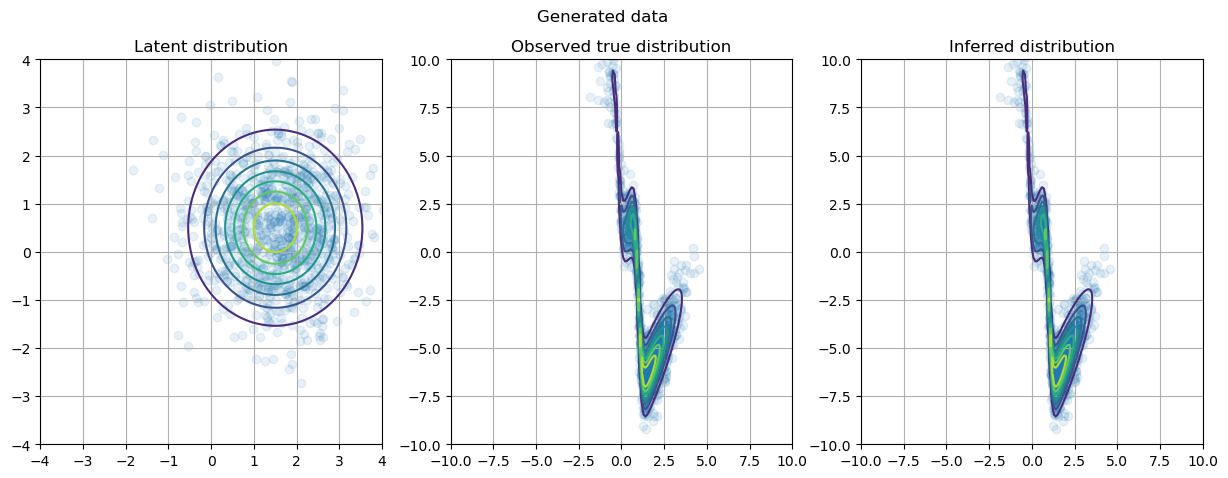

In [10]:
params = Optim.minimizer(res)
inferred_model = FlowModel((AdditiveCouplingLayer(PlanarFlow(params[1], params[2], params[3])),
                            AdditiveCouplingLayer(PlanarFlow(params[4], params[5], params[6]))))
fig, ax = plt.subplots(ncols = 3, figsize=(15,5))
ax[1].scatter(data_x[1,:], data_x[2,:], alpha=0.1)
ax[1].contour(repeat(-5:0.1:5, 1, 101), repeat(-5:0.1:5, 1, 101)', map( (x) -> pdf(MvNormal([1.5, 0.5], I), [x...]), collect(Iterators.product(-5:0.1:5, -5:0.1:5))))
ax[2].scatter(data_y[1,:], data_y[2,:], alpha=0.1)
ax[2].contour(repeat(-10:0.1:10, 1, 201), repeat(-10:0.1:10, 1, 201)', map( (x) -> pdf(MvNormal([1.5, 0.5], I), backward(data_model, [x...])), collect(Iterators.product(-10:0.1:10, -10:0.1:10))))
ax[3].scatter(data_y[1,:], data_y[2,:], alpha=0.1)
ax[3].contour(repeat(-10:0.1:10, 1, 201), repeat(-10:0.1:10, 1, 201)', map( (x) -> pdf(MvNormal([1.5, 0.5], I), backward(inferred_model, [x...])), collect(Iterators.product(-10:0.1:10, -10:0.1:10))))
ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[1].set_xlim(-4,4), ax[1].set_ylim(-4,4), ax[2].set_xlim(-10,10), ax[2].set_ylim(-10,10), ax[3].set_xlim(-10,10), ax[3].set_ylim(-10,10)
fig.suptitle("Generated data")
ax[1].set_title("Latent distribution"), ax[2].set_title("Observed true distribution"), ax[3].set_title("Inferred distribution");